# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.

### First, download the data from: https://www.kaggle.com/ntnu-testimon/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?
### Note: don't use the entire dataset, use a sample instead, with n=100000 elements, so your computer doesn't freeze.

In [44]:
#Necessary Libraries cleaning
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

In [79]:
#Fetching the dataaaaaaa
default = pd.read_csv(r"C:\Users\maria\Desktop\Ironhack\Lab\Module3\Week7\CSVs\Default.csv")

In [80]:
#Getting a random sample of 100000 elements to work with
default_s = default.sample(n=100000, random_state=42)

In [81]:
#cheking the data
default_s.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3737323,278,CASH_IN,330218.42,C632336343,20866.00,351084.42,C834976624,452419.57,122201.15,0,0
264914,15,PAYMENT,11647.08,C1264712553,30370.00,18722.92,M215391829,0.00,0.00,0,0
85647,10,CASH_IN,152264.21,C1746846248,106589.00,258853.21,C1607284477,201303.01,49038.80,0,0
5899326,403,TRANSFER,1551760.63,C333676753,0.00,0.00,C1564353608,3198359.45,4750120.08,0,0
2544263,206,CASH_IN,78172.30,C813403091,2921331.58,2999503.88,C1091768874,415821.90,337649.60,0,0


### What is the distribution of the outcome? 

In [82]:
print(default_s["isFraud"].value_counts())
print(default_s["isFraud"].value_counts()[1]/len(default_s)*100)
# Yup, some balancing required

0    99859
1      141
Name: isFraud, dtype: int64
0.14100000000000001


### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

In [83]:
#Checking the types
default_s.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [84]:
#It's clean Which is nice
default_s.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [85]:
# I'm going to leave the step as an integer, because as is it translates enough information, given that it will most likely
# preserve intuitions like high simulation hours have x impact and low have ....

In [86]:
#I want to check the granularity of categorical variables, to see if they make sense and if they are worth keeping
cat_var = default_s.select_dtypes(exclude = ["int64", "float64"])
for feature in cat_var:
    print(feature,"\\",cat_var[feature].nunique(), cat_var[feature].unique(),"\n" )

type \ 5 ['CASH_IN' 'PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT'] 

nameOrig \ 99999 ['C632336343' 'C1264712553' 'C1746846248' ... 'C387888280' 'C1458432906'
 'C1314607150'] 

nameDest \ 92914 ['C834976624' 'M215391829' 'C1607284477' ... 'C999640037' 'C8292738'
 'M1600734161'] 



In [87]:
# the features nameOrig & nameDest have a high granularity so I don't think it will be worth keeping them
#also there seems to be no advantageous way to bin them in smaller groups
#just to be sure I'm going to do a chi-test to see of they have a high importance
        ## nameOrig vs isFraud
customer_y = pd.crosstab(default_s['nameOrig'], default_s["isFraud"])
customer_y_test = chi2_contingency(customer_y)
if customer_y_test[1]<0.5:
    print("Null hypothesis rejected. They are dependent")
else:
    print("Null hypothesis NOT rejected.")
print("Chi-squared is: ", customer_y_test[0])
        ## nameDest vs isFraud
recipient_y = pd.crosstab(default_s['nameDest'], default_s["isFraud"])
recipient_y_test = chi2_contingency(recipient_y)
if recipient_y_test[1]<0.5:
    print("Null hypothesis rejected. They are dependent")
else:
    print("Null hypothesis NOT rejected.")
print("Chi-squared is: ", recipient_y_test[0])

Null hypothesis rejected. They are dependent
Chi-squared is:  99999.99999999996
Null hypothesis rejected. They are dependent
Chi-squared is:  92956.97240437618


In [88]:
# They appear to have a dependency with is Fraud, neverteless, I choose to drop them becuase of their granularity
default_s.drop(["nameDest","nameOrig"],axis=1,inplace=True)

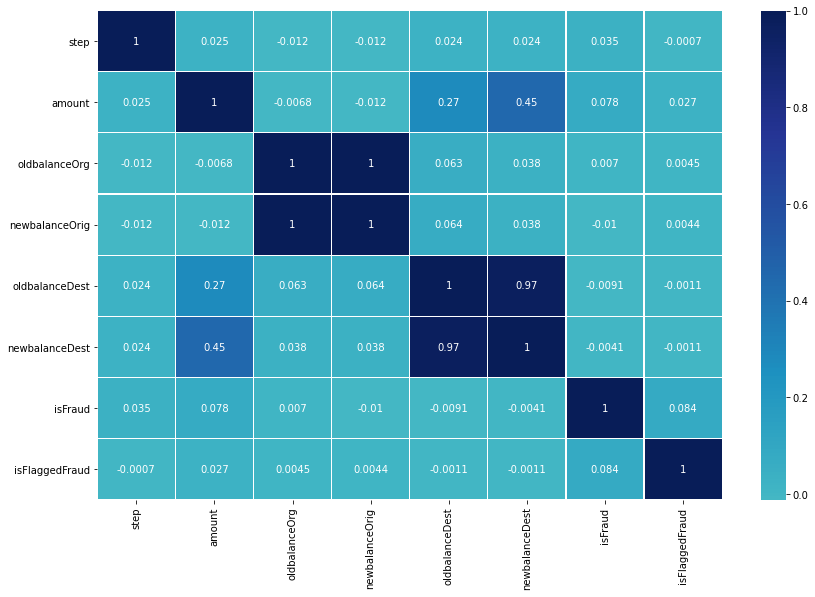

In [89]:
# Now I want to check numeric values and existing correlations
num_var = default_s.select_dtypes(include = ["int64", "float64"]).corr()
# Set up size of figure
f, ax = plt.subplots(figsize=(14, 9))
# Draw the heatmap 
sns.heatmap(num_var, annot=True, cmap = "YlGnBu", center=0, linewidths=.2)   

In [90]:
#Thre are some cases of multicolinearity so I'm going to opt to drop the columns in colinearity that have lowest corr with isFraud
default_s.drop(["oldbalanceOrg","newbalanceDest"],axis=1,inplace = True)

In [91]:
#Last step is converting remaining categorical variabes to sth processable by the algorithm
default_dummy = pd.get_dummies(default_s["type"])
default_ss = pd.concat([default_s,default_dummy], axis=1)
default_ss.drop(["type"],axis=1,inplace=True)

In [92]:
default_ss

,step,amount,newbalanceOrig,oldbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
3737323,278,330218.42,351084.42,452419.57,0,0,1,0,0,0,0
264914,15,11647.08,18722.92,0.00,0,0,0,0,0,1,0
85647,10,152264.21,258853.21,201303.01,0,0,1,0,0,0,0
5899326,403,1551760.63,0.00,3198359.45,0,0,0,0,0,0,1
2544263,206,78172.30,2999503.88,415821.90,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3113342,235,371042.71,2070408.56,4301572.86,0,0,1,0,0,0,0
5156943,357,19494.57,1940583.68,75635.52,0,0,1,0,0,0,0
5189870,369,141519.24,0.00,12853274.23,0,0,0,1,0,0,0
1551677,154,635412.68,694022.68,0.00,0,0,1,0,0,0,0


### Run a logisitc regression classifier and evaluate its accuracy.

In [93]:
#Import libraries models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier

In [94]:
#separating X's and Y
x = default_ss.drop("isFraud", axis=1, inplace=False)
y = default_ss["isFraud"]
#separate our sample to train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
#Get the model (logistic)
log_model = LogisticRegression(max_iter=1000)

In [95]:
#Balancing data, I'm going to choose to downsample (though this will lead to very few rows to train)
correction = pd.concat([x_train, y_train], axis=1)
# Separate defaults (minority) from no defaults (majority)
fraud = correction[correction["isFraud"]==1]
no_fraud = correction[correction["isFraud"]==0]
# Downsample majority class
downsampled = resample(no_fraud, replace=True, n_samples=len(fraud),random_state=0)
# Join together in new dataset
correction = pd.concat([fraud, downsampled])
#Assigning back our train variables
x_train = correction.drop("isFraud", axis=1, inplace=False)
y_train = correction["isFraud"]

In [96]:
#Getting our resampled data and trainnig the model
log_model.fit(x_train,y_train)

LogisticRegression(max_iter=1000)

In [97]:
#Making prediction
y_pred = log_model.predict(x_test)
#Evaluating accuracy and other
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(pd.DataFrame.from_dict(classification_report(y_test,y_pred, output_dict=True)))

0.58575
[[11691  8281]
 [    4    24]]
                      0          1  accuracy     macro avg  weighted avg
precision      0.999658   0.002890   0.58575      0.501274      0.998262
recall         0.585370   0.857143   0.58575      0.721256      0.585750
f1-score       0.738371   0.005760   0.58575      0.372066      0.737346
support    19972.000000  28.000000   0.58575  20000.000000  20000.000000


### Now pick a model of your choice and evaluate its accuracy.

In [98]:
# I'm going to choose random forest 
forest_model = RandomForestClassifier()

In [99]:
#Getting our resampled data and trainnig the model
forest_model.fit(x_train,y_train)

RandomForestClassifier()

In [100]:
#Making prediction
y_pred2 = forest_model.predict(x_test)
#Evaluating accuracy and other
print(accuracy_score(y_test,y_pred2))
print(confusion_matrix(y_test,y_pred2))
print(pd.DataFrame.from_dict(classification_report(y_test,y_pred2, output_dict=True)))

0.91855
[[18346  1626]
 [    3    25]]
                      0          1  accuracy     macro avg  weighted avg
precision      0.999837   0.015142   0.91855      0.507489      0.998458
recall         0.918586   0.892857   0.91855      0.905722      0.918550
f1-score       0.957491   0.029780   0.91855      0.493635      0.956192
support    19972.000000  28.000000   0.91855  20000.000000  20000.000000


### Which model worked better and how do you know?

In [101]:
# The last moedl worked better as alll metrics improved, and though the precision of 1 is pretty bad, that is fine because
#the focus is making sure no one with fraud gets away and with a recall of 89% I would say this model
#does a good job at that

### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.